# Enron Scandal

In [1]:
#imports
import numpy as np 
import pandas as pd
import os,email,sys,re

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns; sns.set_style('whitegrid')

%matplotlib inline

# Network analysis
import networkx as nx

# NLP
from nltk.tokenize.regexp import RegexpTokenizer

from subprocess import check_output

In [36]:
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

from sklearn.decomposition import LatentDirichletAllocation

import gensim
from gensim import corpora
from nltk.corpus import stopwords 
from nltk.stem.wordnet import WordNetLemmatizer
import string
from nltk.stem.porter import PorterStemmer

C:\Users\aswat\Anaconda3\lib\site-packages\gensim\utils.py:862: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [2]:
# Read the data into a DataFrame
emails_df = pd.read_csv('emails.csv')
print(emails_df.shape)
emails_df.head()

(517401, 2)


,file,message
0,allen-p/_sent_mail/1.,Message-ID: <18782981.1075855378110.JavaMail.e...
1,allen-p/_sent_mail/10.,Message-ID: <15464986.1075855378456.JavaMail.e...
2,allen-p/_sent_mail/100.,Message-ID: <24216240.1075855687451.JavaMail.e...
3,allen-p/_sent_mail/1000.,Message-ID: <13505866.1075863688222.JavaMail.e...
4,allen-p/_sent_mail/1001.,Message-ID: <30922949.1075863688243.JavaMail.e...


In [3]:
# A single message looks like this
print(emails_df['message'][0])

Message-ID: <18782981.1075855378110.JavaMail.evans@thyme>
Date: Mon, 14 May 2001 16:39:00 -0700 (PDT)
From: phillip.allen@enron.com
To: tim.belden@enron.com
Subject: 
Mime-Version: 1.0
Content-Type: text/plain; charset=us-ascii
Content-Transfer-Encoding: 7bit
X-From: Phillip K Allen
X-To: Tim Belden <Tim Belden/Enron@EnronXGate>
X-cc: 
X-bcc: 
X-Folder: \Phillip_Allen_Jan2002_1\Allen, Phillip K.\'Sent Mail
X-Origin: Allen-P
X-FileName: pallen (Non-Privileged).pst

Here is our forecast

 


In [4]:
## Helper functions
def get_text_from_email(message):
#To get the content from email objects
    parts = []
    for part in message.walk():
        if part.get_content_type() == 'text/plain':
            parts.append( part.get_payload() )
    return ''.join(parts)

def split_email_addresses(line):
#To separate multiple email addresses
    if line:
        address = line.split(',')
        address = frozenset(map(lambda x: x.strip(), address))
    else:
        address = None
    return address

In [5]:
# Parse the emails into a list email objects
messages = list(map(email.message_from_string, emails_df['message']))
emails_df.drop('message', axis=1, inplace=True)

In [6]:
messages[0].keys()

['Message-ID',
 'Date',
 'From',
 'To',
 'Subject',
 'Mime-Version',
 'Content-Type',
 'Content-Transfer-Encoding',
 'X-From',
 'X-To',
 'X-cc',
 'X-bcc',
 'X-Folder',
 'X-Origin',
 'X-FileName']

In [7]:
# Get fields from parsed email objects
keys = messages[0].keys()
for key in keys:
    emails_df[key] = [doc[key] for doc in messages]

In [8]:
emails_df.head()

,file,Message-ID,Date,From,To,Subject,Mime-Version,Content-Type,Content-Transfer-Encoding,X-From,X-To,X-cc,X-bcc,X-Folder,X-Origin,X-FileName
0,allen-p/_sent_mail/1.,<18782981.1075855378110.JavaMail.evans@thyme>,"Mon, 14 May 2001 16:39:00 -0700 (PDT)",phillip.allen@enron.com,tim.belden@enron.com,,1.0,text/plain; charset=us-ascii,7bit,Phillip K Allen,Tim Belden <Tim Belden/Enron@EnronXGate>,,,"\Phillip_Allen_Jan2002_1\Allen, Phillip K.\'Se...",Allen-P,pallen (Non-Privileged).pst
1,allen-p/_sent_mail/10.,<15464986.1075855378456.JavaMail.evans@thyme>,"Fri, 4 May 2001 13:51:00 -0700 (PDT)",phillip.allen@enron.com,john.lavorato@enron.com,Re:,1.0,text/plain; charset=us-ascii,7bit,Phillip K Allen,John J Lavorato <John J Lavorato/ENRON@enronXg...,,,"\Phillip_Allen_Jan2002_1\Allen, Phillip K.\'Se...",Allen-P,pallen (Non-Privileged).pst
2,allen-p/_sent_mail/100.,<24216240.1075855687451.JavaMail.evans@thyme>,"Wed, 18 Oct 2000 03:00:00 -0700 (PDT)",phillip.allen@enron.com,leah.arsdall@enron.com,Re: test,1.0,text/plain; charset=us-ascii,7bit,Phillip K Allen,Leah Van Arsdall,,,\Phillip_Allen_Dec2000\Notes Folders\'sent mail,Allen-P,pallen.nsf
3,allen-p/_sent_mail/1000.,<13505866.1075863688222.JavaMail.evans@thyme>,"Mon, 23 Oct 2000 06:13:00 -0700 (PDT)",phillip.allen@enron.com,randall.gay@enron.com,,1.0,text/plain; charset=us-ascii,7bit,Phillip K Allen,Randall L Gay,,,\Phillip_Allen_Dec2000\Notes Folders\'sent mail,Allen-P,pallen.nsf
4,allen-p/_sent_mail/1001.,<30922949.1075863688243.JavaMail.evans@thyme>,"Thu, 31 Aug 2000 05:07:00 -0700 (PDT)",phillip.allen@enron.com,greg.piper@enron.com,Re: Hello,1.0,text/plain; charset=us-ascii,7bit,Phillip K Allen,Greg Piper,,,\Phillip_Allen_Dec2000\Notes Folders\'sent mail,Allen-P,pallen.nsf


In [9]:
# Parse content from emails
emails_df['content'] = list(map(get_text_from_email, messages))
# Split multiple email addresses
emails_df['From'] = emails_df['From'].map(split_email_addresses)
emails_df['To'] = emails_df['To'].map(split_email_addresses)

In [10]:
emails_df.head()

,file,Message-ID,Date,From,To,Subject,Mime-Version,Content-Type,Content-Transfer-Encoding,X-From,X-To,X-cc,X-bcc,X-Folder,X-Origin,X-FileName,content
0,allen-p/_sent_mail/1.,<18782981.1075855378110.JavaMail.evans@thyme>,"Mon, 14 May 2001 16:39:00 -0700 (PDT)",(phillip.allen@enron.com),(tim.belden@enron.com),,1.0,text/plain; charset=us-ascii,7bit,Phillip K Allen,Tim Belden <Tim Belden/Enron@EnronXGate>,,,"\Phillip_Allen_Jan2002_1\Allen, Phillip K.\'Se...",Allen-P,pallen (Non-Privileged).pst,Here is our forecast\n\n
1,allen-p/_sent_mail/10.,<15464986.1075855378456.JavaMail.evans@thyme>,"Fri, 4 May 2001 13:51:00 -0700 (PDT)",(phillip.allen@enron.com),(john.lavorato@enron.com),Re:,1.0,text/plain; charset=us-ascii,7bit,Phillip K Allen,John J Lavorato <John J Lavorato/ENRON@enronXg...,,,"\Phillip_Allen_Jan2002_1\Allen, Phillip K.\'Se...",Allen-P,pallen (Non-Privileged).pst,Traveling to have a business meeting takes the...
2,allen-p/_sent_mail/100.,<24216240.1075855687451.JavaMail.evans@thyme>,"Wed, 18 Oct 2000 03:00:00 -0700 (PDT)",(phillip.allen@enron.com),(leah.arsdall@enron.com),Re: test,1.0,text/plain; charset=us-ascii,7bit,Phillip K Allen,Leah Van Arsdall,,,\Phillip_Allen_Dec2000\Notes Folders\'sent mail,Allen-P,pallen.nsf,test successful. way to go!!!
3,allen-p/_sent_mail/1000.,<13505866.1075863688222.JavaMail.evans@thyme>,"Mon, 23 Oct 2000 06:13:00 -0700 (PDT)",(phillip.allen@enron.com),(randall.gay@enron.com),,1.0,text/plain; charset=us-ascii,7bit,Phillip K Allen,Randall L Gay,,,\Phillip_Allen_Dec2000\Notes Folders\'sent mail,Allen-P,pallen.nsf,"Randy,\n\n Can you send me a schedule of the s..."
4,allen-p/_sent_mail/1001.,<30922949.1075863688243.JavaMail.evans@thyme>,"Thu, 31 Aug 2000 05:07:00 -0700 (PDT)",(phillip.allen@enron.com),(greg.piper@enron.com),Re: Hello,1.0,text/plain; charset=us-ascii,7bit,Phillip K Allen,Greg Piper,,,\Phillip_Allen_Dec2000\Notes Folders\'sent mail,Allen-P,pallen.nsf,Let's shoot for Tuesday at 11:45.


In [11]:
# Extract the root of 'file' as 'user'
emails_df['user'] = emails_df['file'].map(lambda x:x.split('/')[0])
del messages

emails_df.head()

,file,Message-ID,Date,From,To,Subject,Mime-Version,Content-Type,Content-Transfer-Encoding,X-From,X-To,X-cc,X-bcc,X-Folder,X-Origin,X-FileName,content,user
0,allen-p/_sent_mail/1.,<18782981.1075855378110.JavaMail.evans@thyme>,"Mon, 14 May 2001 16:39:00 -0700 (PDT)",(phillip.allen@enron.com),(tim.belden@enron.com),,1.0,text/plain; charset=us-ascii,7bit,Phillip K Allen,Tim Belden <Tim Belden/Enron@EnronXGate>,,,"\Phillip_Allen_Jan2002_1\Allen, Phillip K.\'Se...",Allen-P,pallen (Non-Privileged).pst,Here is our forecast\n\n,allen-p
1,allen-p/_sent_mail/10.,<15464986.1075855378456.JavaMail.evans@thyme>,"Fri, 4 May 2001 13:51:00 -0700 (PDT)",(phillip.allen@enron.com),(john.lavorato@enron.com),Re:,1.0,text/plain; charset=us-ascii,7bit,Phillip K Allen,John J Lavorato <John J Lavorato/ENRON@enronXg...,,,"\Phillip_Allen_Jan2002_1\Allen, Phillip K.\'Se...",Allen-P,pallen (Non-Privileged).pst,Traveling to have a business meeting takes the...,allen-p
2,allen-p/_sent_mail/100.,<24216240.1075855687451.JavaMail.evans@thyme>,"Wed, 18 Oct 2000 03:00:00 -0700 (PDT)",(phillip.allen@enron.com),(leah.arsdall@enron.com),Re: test,1.0,text/plain; charset=us-ascii,7bit,Phillip K Allen,Leah Van Arsdall,,,\Phillip_Allen_Dec2000\Notes Folders\'sent mail,Allen-P,pallen.nsf,test successful. way to go!!!,allen-p
3,allen-p/_sent_mail/1000.,<13505866.1075863688222.JavaMail.evans@thyme>,"Mon, 23 Oct 2000 06:13:00 -0700 (PDT)",(phillip.allen@enron.com),(randall.gay@enron.com),,1.0,text/plain; charset=us-ascii,7bit,Phillip K Allen,Randall L Gay,,,\Phillip_Allen_Dec2000\Notes Folders\'sent mail,Allen-P,pallen.nsf,"Randy,\n\n Can you send me a schedule of the s...",allen-p
4,allen-p/_sent_mail/1001.,<30922949.1075863688243.JavaMail.evans@thyme>,"Thu, 31 Aug 2000 05:07:00 -0700 (PDT)",(phillip.allen@enron.com),(greg.piper@enron.com),Re: Hello,1.0,text/plain; charset=us-ascii,7bit,Phillip K Allen,Greg Piper,,,\Phillip_Allen_Dec2000\Notes Folders\'sent mail,Allen-P,pallen.nsf,Let's shoot for Tuesday at 11:45.,allen-p


In [12]:
emails_df.shape

(517401, 18)

In [13]:
emails_df.describe()

,file,Message-ID,Date,From,To,Subject,Mime-Version,Content-Type,Content-Transfer-Encoding,X-From,X-To,X-cc,X-bcc,X-Folder,X-Origin,X-FileName,content,user
count,517401,517401,517401,517401,495554,517401,517372,517372,517372,517372,517372,517372,517372,517372,517372,517372,517401,517401
unique,517401,517401,224128,20328,54748,159290,1,2,3,27980,73552,33701,132,5335,259,429,249025,150
top,kitchen-l/_americas/regulatory/108.,<13337609.1075853858170.JavaMail.evans@thyme>,"Wed, 27 Jun 2001 16:02:00 -0700 (PDT)",(kay.mann@enron.com),(pete.davis@enron.com),,1.0,text/plain; charset=us-ascii,7bit,Kay Mann,,,,\Kay_Mann_June2001_1\Notes Folders\All documents,Kaminski-V,vkamins.nsf,"As you know, Enron Net Works (ENW) and Enron G...",kaminski-v
freq,1,1,1118,16735,9155,19187,517372,479286,494971,16324,9124,388486,517197,6639,26995,24029,112,28465


In [14]:
# Set index and drop columns with two few values
emails_df = emails_df.set_index('Message-ID')\
    .drop(['file', 'Mime-Version', 'Content-Type', 'Content-Transfer-Encoding'], axis=1)

In [15]:
emails_df.head()

,Date,From,To,Subject,X-From,X-To,X-cc,X-bcc,X-Folder,X-Origin,X-FileName,content,user
Message-ID,,,,,,,,,,,,,
<18782981.1075855378110.JavaMail.evans@thyme>,"Mon, 14 May 2001 16:39:00 -0700 (PDT)",(phillip.allen@enron.com),(tim.belden@enron.com),,Phillip K Allen,Tim Belden <Tim Belden/Enron@EnronXGate>,,,"\Phillip_Allen_Jan2002_1\Allen, Phillip K.\'Se...",Allen-P,pallen (Non-Privileged).pst,Here is our forecast\n\n,allen-p
<15464986.1075855378456.JavaMail.evans@thyme>,"Fri, 4 May 2001 13:51:00 -0700 (PDT)",(phillip.allen@enron.com),(john.lavorato@enron.com),Re:,Phillip K Allen,John J Lavorato <John J Lavorato/ENRON@enronXg...,,,"\Phillip_Allen_Jan2002_1\Allen, Phillip K.\'Se...",Allen-P,pallen (Non-Privileged).pst,Traveling to have a business meeting takes the...,allen-p
<24216240.1075855687451.JavaMail.evans@thyme>,"Wed, 18 Oct 2000 03:00:00 -0700 (PDT)",(phillip.allen@enron.com),(leah.arsdall@enron.com),Re: test,Phillip K Allen,Leah Van Arsdall,,,\Phillip_Allen_Dec2000\Notes Folders\'sent mail,Allen-P,pallen.nsf,test successful. way to go!!!,allen-p
<13505866.1075863688222.JavaMail.evans@thyme>,"Mon, 23 Oct 2000 06:13:00 -0700 (PDT)",(phillip.allen@enron.com),(randall.gay@enron.com),,Phillip K Allen,Randall L Gay,,,\Phillip_Allen_Dec2000\Notes Folders\'sent mail,Allen-P,pallen.nsf,"Randy,\n\n Can you send me a schedule of the s...",allen-p
<30922949.1075863688243.JavaMail.evans@thyme>,"Thu, 31 Aug 2000 05:07:00 -0700 (PDT)",(phillip.allen@enron.com),(greg.piper@enron.com),Re: Hello,Phillip K Allen,Greg Piper,,,\Phillip_Allen_Dec2000\Notes Folders\'sent mail,Allen-P,pallen.nsf,Let's shoot for Tuesday at 11:45.,allen-p


In [16]:
# Parse datetime
emails_df['Date'] = pd.to_datetime(emails_df['Date'], infer_datetime_format=True)
emails_df.dtypes

Date          datetime64[ns]
From                  object
To                    object
Subject               object
X-From                object
X-To                  object
X-cc                  object
X-bcc                 object
X-Folder              object
X-Origin              object
X-FileName            object
content               object
user                  object
dtype: object

In [17]:
emails_df.head()

,Date,From,To,Subject,X-From,X-To,X-cc,X-bcc,X-Folder,X-Origin,X-FileName,content,user
Message-ID,,,,,,,,,,,,,
<18782981.1075855378110.JavaMail.evans@thyme>,2001-05-14 23:39:00,(phillip.allen@enron.com),(tim.belden@enron.com),,Phillip K Allen,Tim Belden <Tim Belden/Enron@EnronXGate>,,,"\Phillip_Allen_Jan2002_1\Allen, Phillip K.\'Se...",Allen-P,pallen (Non-Privileged).pst,Here is our forecast\n\n,allen-p
<15464986.1075855378456.JavaMail.evans@thyme>,2001-05-04 20:51:00,(phillip.allen@enron.com),(john.lavorato@enron.com),Re:,Phillip K Allen,John J Lavorato <John J Lavorato/ENRON@enronXg...,,,"\Phillip_Allen_Jan2002_1\Allen, Phillip K.\'Se...",Allen-P,pallen (Non-Privileged).pst,Traveling to have a business meeting takes the...,allen-p
<24216240.1075855687451.JavaMail.evans@thyme>,2000-10-18 10:00:00,(phillip.allen@enron.com),(leah.arsdall@enron.com),Re: test,Phillip K Allen,Leah Van Arsdall,,,\Phillip_Allen_Dec2000\Notes Folders\'sent mail,Allen-P,pallen.nsf,test successful. way to go!!!,allen-p
<13505866.1075863688222.JavaMail.evans@thyme>,2000-10-23 13:13:00,(phillip.allen@enron.com),(randall.gay@enron.com),,Phillip K Allen,Randall L Gay,,,\Phillip_Allen_Dec2000\Notes Folders\'sent mail,Allen-P,pallen.nsf,"Randy,\n\n Can you send me a schedule of the s...",allen-p
<30922949.1075863688243.JavaMail.evans@thyme>,2000-08-31 12:07:00,(phillip.allen@enron.com),(greg.piper@enron.com),Re: Hello,Phillip K Allen,Greg Piper,,,\Phillip_Allen_Dec2000\Notes Folders\'sent mail,Allen-P,pallen.nsf,Let's shoot for Tuesday at 11:45.,allen-p


# email sent with Year, Day of week, Hour

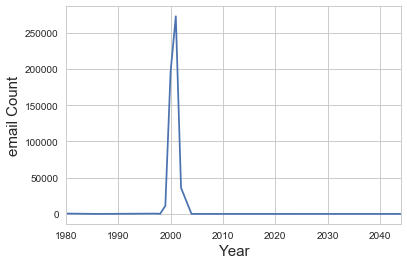

In [18]:
ax = emails_df.groupby(emails_df['Date'].dt.year)['content'].count().plot()
ax.set_xlabel('Year', fontsize=15)
ax.set_ylabel('email Count', fontsize=15)

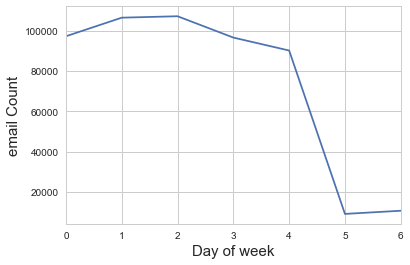

In [19]:
ax = emails_df.groupby(emails_df['Date'].dt.dayofweek)['content'].count().plot()
ax.set_xlabel('Day of week', fontsize=15)
ax.set_ylabel('email Count', fontsize=15)

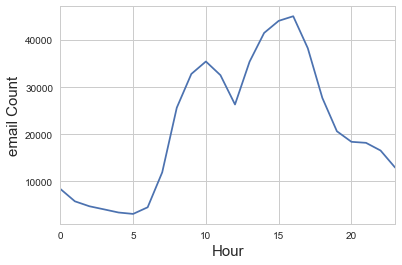

In [20]:
ax = emails_df.groupby(emails_df['Date'].dt.hour)['content'].count().plot()
ax.set_xlabel('Hour', fontsize=15)
ax.set_ylabel('email Count', fontsize=15)

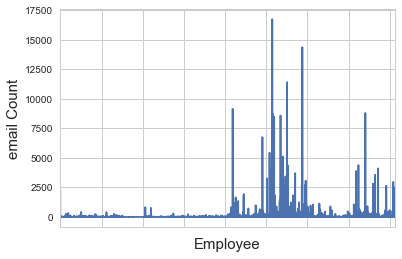

In [21]:
ax = emails_df.groupby(emails_df['From'])['content'].count()
ax=ax.plot()
ax.set_xticklabels([])
ax.set_xlabel('Employee', fontsize=15)
ax.set_ylabel('email Count', fontsize=15)

In [22]:
# Count words in Subjects and content
tokenizer = RegexpTokenizer(r'(?u)\b\w\w+\b')
emails_df['subject_wc'] = emails_df['Subject'].map(lambda x: len(tokenizer.tokenize(x)))
emails_df['content_wc'] = emails_df['content'].map(lambda x: len(tokenizer.tokenize(x)))

In [23]:
emails_df.head()

,Date,From,To,Subject,X-From,X-To,X-cc,X-bcc,X-Folder,X-Origin,X-FileName,content,user,subject_wc,content_wc
Message-ID,,,,,,,,,,,,,,,
<18782981.1075855378110.JavaMail.evans@thyme>,2001-05-14 23:39:00,(phillip.allen@enron.com),(tim.belden@enron.com),,Phillip K Allen,Tim Belden <Tim Belden/Enron@EnronXGate>,,,"\Phillip_Allen_Jan2002_1\Allen, Phillip K.\'Se...",Allen-P,pallen (Non-Privileged).pst,Here is our forecast\n\n,allen-p,0,4
<15464986.1075855378456.JavaMail.evans@thyme>,2001-05-04 20:51:00,(phillip.allen@enron.com),(john.lavorato@enron.com),Re:,Phillip K Allen,John J Lavorato <John J Lavorato/ENRON@enronXg...,,,"\Phillip_Allen_Jan2002_1\Allen, Phillip K.\'Se...",Allen-P,pallen (Non-Privileged).pst,Traveling to have a business meeting takes the...,allen-p,1,130
<24216240.1075855687451.JavaMail.evans@thyme>,2000-10-18 10:00:00,(phillip.allen@enron.com),(leah.arsdall@enron.com),Re: test,Phillip K Allen,Leah Van Arsdall,,,\Phillip_Allen_Dec2000\Notes Folders\'sent mail,Allen-P,pallen.nsf,test successful. way to go!!!,allen-p,2,5
<13505866.1075863688222.JavaMail.evans@thyme>,2000-10-23 13:13:00,(phillip.allen@enron.com),(randall.gay@enron.com),,Phillip K Allen,Randall L Gay,,,\Phillip_Allen_Dec2000\Notes Folders\'sent mail,Allen-P,pallen.nsf,"Randy,\n\n Can you send me a schedule of the s...",allen-p,0,32
<30922949.1075863688243.JavaMail.evans@thyme>,2000-08-31 12:07:00,(phillip.allen@enron.com),(greg.piper@enron.com),Re: Hello,Phillip K Allen,Greg Piper,,,\Phillip_Allen_Dec2000\Notes Folders\'sent mail,Allen-P,pallen.nsf,Let's shoot for Tuesday at 11:45.,allen-p,2,7


In [24]:
grouped_by_people = emails_df.groupby('user').agg({
        'content': 'count', 
        'subject_wc': 'mean',
        'content_wc': 'mean',
    })

In [25]:
grouped_by_people.head()

,content,subject_wc,content_wc
user,,,
allen-p,3034,3.383652,178.506262
arnold-j,4898,3.261127,266.268885
arora-h,654,4.836391,340.730887
badeer-r,877,6.060433,264.281642
bailey-s,478,4.587866,162.587866


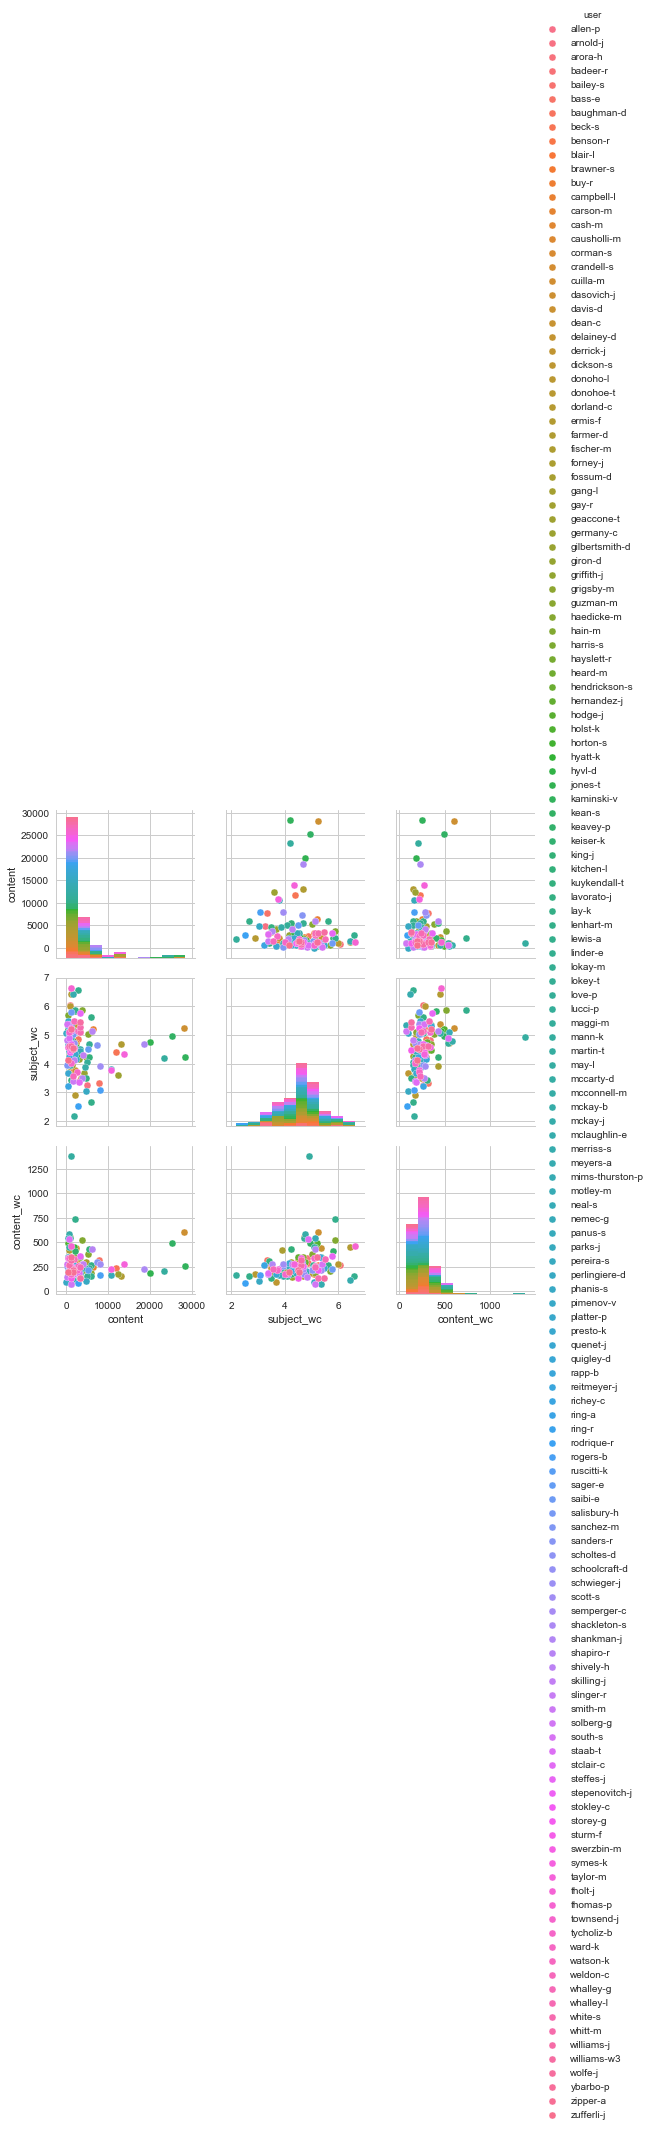

In [26]:
#Pair plot
sns.pairplot(grouped_by_people.reset_index(),hue='user')

# Social network analysis

In [27]:
sub_df = emails_df[['From', 'To', 'Date']].dropna()
sub_df.shape

(495554, 3)

In [28]:
# drop emails sending to multiple addresses
sub_df = sub_df.loc[sub_df['To'].map(len) == 1]
sub_df.shape

(354600, 3)

In [29]:
sub_df = sub_df.groupby(['From', 'To']).count().reset_index()
sub_df.head()

,From,To,Date
0,(phillip.allen@enron.com),(tim.belden@enron.com),16
1,(phillip.allen@enron.com),(ben.jacoby@enron.com),3
2,(phillip.allen@enron.com),(vladimir.gorny@enron.com),8
3,(phillip.allen@enron.com),(tbland@enron.com),3
4,(phillip.allen@enron.com),(fescofield@1411west.com),4


In [30]:
# Unpack frozensets
sub_df['From'] = sub_df['From'].map(lambda x: next(iter(x)))
sub_df['To'] = sub_df['To'].map(lambda x: next(iter(x)))

In [31]:
# rename column
sub_df.rename(columns={'Date': 'count'}, inplace=True)


## Person who sent the highest email and to whom

In [32]:
sub_df.sort_values('count', ascending=False).head(10)

,From,To,count
17908,pete.davis@enron.com,pete.davis@enron.com,9141
38033,vince.kaminski@enron.com,vkaminski@aol.com,4308
28920,enron.announcements@enron.com,all.worldwide@enron.com,2206
28935,enron.announcements@enron.com,all.houston@enron.com,1701
26510,kay.mann@enron.com,suzanne.adams@enron.com,1528
38031,vince.kaminski@enron.com,shirley.crenshaw@enron.com,1190
14564,steven.kean@enron.com,maureen.mcvicker@enron.com,1014
26309,kay.mann@enron.com,nmann@erac.com,980
18926,kate.symes@enron.com,evelyn.metoyer@enron.com,915
18930,kate.symes@enron.com,kerri.thompson@enron.com,859


Apparently some people send a lot of emails to themselves. It maybe very interesting to look at the differences between emails sent to selves and to others.

In [33]:
# Make a network of email sender and receipients
G = nx.from_pandas_dataframe(sub_df, 'From', 'To', edge_attr='count', create_using=nx.DiGraph())
print('Number of nodes: %d, Number of edges: %d' % (G.number_of_nodes(), G.number_of_edges()))

Number of nodes: 25396, Number of edges: 56144


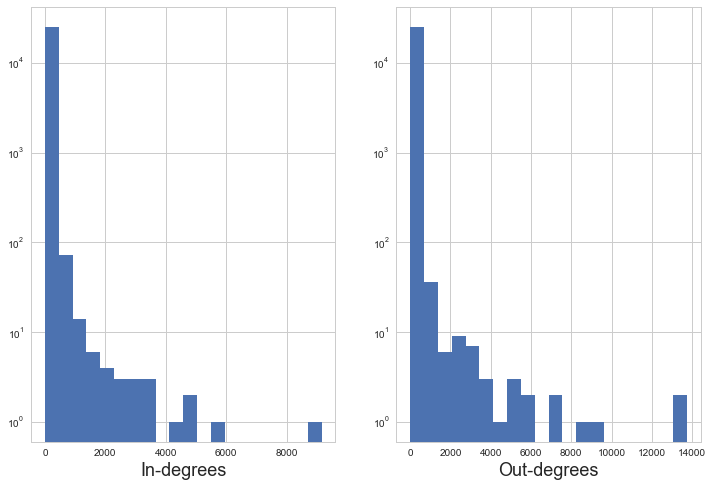

In [34]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12, 8))
ax1.hist(list(G.in_degree(weight='count').values()), log=True, bins=20)
ax1.set_xlabel('In-degrees', fontsize=18)

ax2.hist(list(G.out_degree(weight='count').values()), log=True, bins=20)
ax2.set_xlabel('Out-degrees', fontsize=18)

Looks like scale-free degree distribution

In [38]:
# Clean Function

def clean(text):
    stop = set(stopwords.words('english'))
    stop.update(("to","cc","subject","http","from","sent"))
    exclude = set(string.punctuation) 
    lemma = WordNetLemmatizer()
    porter= PorterStemmer()
    
    text=text.rstrip()
    text = re.sub(r'[^a-zA-Z]', ' ', text)
    stop_free = " ".join([i for i in text.lower().split() if((i not in stop) and (not i.isdigit()))])
    punc_free = ''.join(ch for ch in stop_free if ch not in exclude)
    normalized = " ".join(lemma.lemmatize(word) for word in punc_free.split())
    #stem = " ".join(porter.stem(token) for token in normalized.split())
    
    return normalized

In [39]:
analysis_df=emails_df[['From', 'To', 'Date','content']].dropna().copy()
analysis_df = analysis_df.loc[analysis_df['To'].map(len) == 1]
sub_df=analysis_df.sample(1000)

In [40]:
sub_df

,From,To,Date,content
Message-ID,,,,
<30850102.1075842014948.JavaMail.evans@thyme>,(bob.shults@enron.com),(andy.zipper@enron.com),2002-01-30 20:39:04,"Andy,\n\nStephanie Sever has contacted ICE and..."
<25994222.1075842480537.JavaMail.evans@thyme>,(mary.miller@enron.com),(drew.fossum@enron.com),2000-12-08 17:23:00,"The anwser is no, we didn't respond to 637 nor..."
<3068883.1075847314843.JavaMail.evans@thyme>,(tana.jones@enron.com),(mark.greenberg@enron.com),2001-03-05 09:03:00,Is this the final form?\n\n\n\n\tMark Greenber...
<18485447.1075858505480.JavaMail.evans@thyme>,(virginia.thompson@enron.com),(mike.purcell@enron.com),2001-06-07 17:07:42,"Mike,\n\nFYI.\n\nGeir had to buy transmisison ..."
<32981943.1075858511884.JavaMail.evans@thyme>,(crcommunications@caiso.com),(scsettlecontacts@caiso.com),2001-07-13 18:28:35,IMPORTANT NOTICE\nApril Final Market and GMC I...
<9776380.1075857690950.JavaMail.evans@thyme>,(lavorato@enron.com),(john.zufferli@enron.com),2001-02-05 21:05:12,Send me a cleaner summary of your curve on 1/1...
<18670230.1075853808996.JavaMail.evans@thyme>,(chris.germany@enron.com),(mary.franklin@enron.com),2000-03-21 11:17:00,I always have time for you. I'm out all day t...
<761122.1075845579901.JavaMail.evans@thyme>,(kay.mann@enron.com),(kathleen.clark@enron.com),2000-07-05 10:23:00,Did you get this? The address for you looks o...
<470846.1075847014937.JavaMail.evans@thyme>,(bridgette.anderson@enron.com),(karen.lambert@enron.com),2000-09-29 18:37:00,"Karen et al.,\n\nTo begin with, I contacted Le..."


In [43]:
text_clean=[]
for text in sub_df['content']:
    text_clean.append(clean(text).split())

In [46]:
text_clean[:1]

[['andy',
  'stephanie',
  'sever',
  'contacted',
  'ice',
  'requested',
  'form',
  'expect',
  'soon',
  'kevin',
  'already',
  'given',
  'list',
  'get',
  'access',
  'ice',
  'send',
  'list',
  'know',
  'get',
  'access',
  'bob',
  'shults',
  'enrononline',
  'llc',
  'houston',
  'texas',
  'cell',
  'fax',
  'home',
  'bob',
  'shults',
  'enron',
  'com',
  'rshults',
  'houston',
  'rr',
  'com']]

In [47]:
dictionary = corpora.Dictionary(text_clean)
text_term_matrix = [dictionary.doc2bow(text) for text in text_clean]

In [49]:
text_term_matrix

[[(0, 1),
  (1, 1),
  (2, 1),
  (3, 1),
  (4, 2),
  (5, 1),
  (6, 1),
  (7, 1),
  (8, 1),
  (9, 1),
  (10, 1),
  (11, 1),
  (12, 2),
  (13, 2),
  (14, 2),
  (15, 1),
  (16, 1),
  (17, 2),
  (18, 2),
  (19, 1),
  (20, 1),
  (21, 2),
  (22, 1),
  (23, 1),
  (24, 1),
  (25, 1),
  (26, 1),
  (27, 2),
  (28, 1),
  (29, 1)],
 [(10, 1),
  (26, 10),
  (30, 1),
  (31, 4),
  (32, 1),
  (33, 1),
  (34, 1),
  (35, 1),
  (36, 1),
  (37, 1),
  (38, 1),
  (39, 1),
  (40, 5),
  (41, 1),
  (42, 1),
  (43, 2),
  (44, 1),
  (45, 1),
  (46, 1),
  (47, 1),
  (48, 1),
  (49, 1),
  (50, 1),
  (51, 2),
  (52, 1),
  (53, 1),
  (54, 1),
  (55, 1),
  (56, 1),
  (57, 1),
  (58, 1),
  (59, 1),
  (60, 1),
  (61, 1)],
 [(6, 1),
  (16, 1),
  (26, 2),
  (27, 1),
  (62, 1),
  (63, 5),
  (64, 2),
  (65, 1),
  (66, 2),
  (67, 4),
  (68, 1),
  (69, 1),
  (70, 1),
  (71, 1),
  (72, 1),
  (73, 1),
  (74, 1),
  (75, 1),
  (76, 1),
  (77, 1),
  (78, 1),
  (79, 1),
  (80, 1),
  (81, 1),
  (82, 1),
  (83, 1),
  (84, 1),
  (85, 

In [50]:
Lda = gensim.models.ldamodel.LdaModel
ldamodel = Lda(text_term_matrix, num_topics=4, id2word = dictionary, passes=30)

In [51]:
ldamodel

In [52]:
print(ldamodel.print_topics(num_topics=4, num_words=10))

[(0, '0.021*"com" + 0.018*"enron" + 0.007*"please" + 0.007*"ect" + 0.006*"message" + 0.005*"e" + 0.005*"pm" + 0.004*"original" + 0.004*"www" + 0.004*"mail"'), (1, '0.050*"enron" + 0.041*"ect" + 0.025*"hou" + 0.011*"ee" + 0.010*"pm" + 0.010*"com" + 0.008*"folder" + 0.008*"synchronizing" + 0.007*"corp" + 0.007*"na"'), (2, '0.011*"power" + 0.010*"market" + 0.008*"energy" + 0.008*"california" + 0.007*"state" + 0.007*"said" + 0.007*"gas" + 0.007*"price" + 0.006*"new" + 0.005*"utility"'), (3, '0.023*"com" + 0.016*"image" + 0.011*"td" + 0.009*"www" + 0.009*"tr" + 0.006*"span" + 0.006*"class" + 0.006*"p" + 0.006*"font" + 0.006*"width"')]


In [53]:
eng_stopwords = set(stopwords.words('english'))
def clean_text(text):
    text = re.sub(r'[^a-zA-Z]', ' ', text)
    words = text.lower().split()
    words = [w for w in words if w not in eng_stopwords]
    return ' '.join(words)

analysis_df["clean_content"]=analysis_df.content.apply(clean_text)

In [54]:
wordvector = TfidfVectorizer(analyzer='word', stop_words='english', max_df=0.4, min_df=5)
short_analysis=analysis_df.sample(5000)
wordvector_fit = wordvector.fit_transform(short_analysis.clean_content)
feature = wordvector.get_feature_names()

In [55]:
N = 4
clf = KMeans(n_clusters=N, 
            max_iter=50, 
            init='k-means++', 
            n_init=1)
labels = clf.fit_predict(wordvector_fit)

In [57]:
wordvector_fit_2d = wordvector_fit.todense()
pca = PCA(n_components=2).fit(wordvector_fit_2d)
datapoint = pca.transform(wordvector_fit_2d)

In [58]:
print(ldamodel.print_topics(num_topics=4, num_words=10))

[(0, '0.021*"com" + 0.018*"enron" + 0.007*"please" + 0.007*"ect" + 0.006*"message" + 0.005*"e" + 0.005*"pm" + 0.004*"original" + 0.004*"www" + 0.004*"mail"'), (1, '0.050*"enron" + 0.041*"ect" + 0.025*"hou" + 0.011*"ee" + 0.010*"pm" + 0.010*"com" + 0.008*"folder" + 0.008*"synchronizing" + 0.007*"corp" + 0.007*"na"'), (2, '0.011*"power" + 0.010*"market" + 0.008*"energy" + 0.008*"california" + 0.007*"state" + 0.007*"said" + 0.007*"gas" + 0.007*"price" + 0.006*"new" + 0.005*"utility"'), (3, '0.023*"com" + 0.016*"image" + 0.011*"td" + 0.009*"www" + 0.009*"tr" + 0.006*"span" + 0.006*"class" + 0.006*"p" + 0.006*"font" + 0.006*"width"')]


In [59]:
print([(0, '0.012*"enron" + 0.012*"deal" + 0.010*"agreement" + 0.008*"change" + 0.008*"contract" + 0.008*"corp" + 0.007*"fax" + 0.005*"houston" + 0.005*"date" + 0.005*"america"'), (1, '0.005*"message" + 0.005*"origin" + 0.004*"pleas" + 0.004*"email" + 0.004*"thank" + 0.003*"attach" + 0.003*"file" + 0.003*"copy" + 0.003*"inform" + 0.003*"receive"'), (2, '0.015*"thank" + 0.008*"call" + 0.005*"time" + 0.004*"meet" + 0.003*"look" + 0.003*"week" + 0.003*"day" + 0.003*"lunch" + 0.003*"talk" + 0.003*"hello"'), (3, '0.016*"market" + 0.009*"gas" + 0.008*"price" + 0.005*"power" + 0.004*"company" + 0.004*"energy" + 0.003*"business" + 0.003*"service" + 0.003*"manage" + 0.003*"fare"')])

[(0, '0.012*"enron" + 0.012*"deal" + 0.010*"agreement" + 0.008*"change" + 0.008*"contract" + 0.008*"corp" + 0.007*"fax" + 0.005*"houston" + 0.005*"date" + 0.005*"america"'), (1, '0.005*"message" + 0.005*"origin" + 0.004*"pleas" + 0.004*"email" + 0.004*"thank" + 0.003*"attach" + 0.003*"file" + 0.003*"copy" + 0.003*"inform" + 0.003*"receive"'), (2, '0.015*"thank" + 0.008*"call" + 0.005*"time" + 0.004*"meet" + 0.003*"look" + 0.003*"week" + 0.003*"day" + 0.003*"lunch" + 0.003*"talk" + 0.003*"hello"'), (3, '0.016*"market" + 0.009*"gas" + 0.008*"price" + 0.005*"power" + 0.004*"company" + 0.004*"energy" + 0.003*"business" + 0.003*"service" + 0.003*"manage" + 0.003*"fare"')]
